# Import the data

In [1]:
# Import necessary packages
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
from matplotlib.dates import DateFormatter
import datetime
import pandas as pd
import pickle
from bs4 import BeautifulSoup
import requests
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('dutch') + ["rt", "nan", "NaN"] 

# Import the data and make sure that:
# 'tweet_hashtags' column is a list
data = pd.read_csv("~/Documents/Github Repository/early-warning-twitter/Original datasets/rotterdam-data-twitter-api.csv", converters={'hashtags':eval}, index_col=0)

In [2]:
# Change columns to the right date types
data["created_at"] = pd.to_datetime(data["created_at"])

# Add 2 hours to created_at column
# Original datetime is in UTC, but The Netherlands is in UTC+2
data["created_at"] = data["created_at"] + pd.Timedelta(hours=2)

data = data[(data["created_at"]>="2020-06-03 14:00:00")&(data["created_at"]<="2020-06-03 18:15:06")]

data["count"]=1

data.drop_duplicates('status_id', inplace=True)
data = data.sort_values('created_at', ascending=True)
data.reset_index(inplace=True, drop=True)

# Descriptive statistics

In [3]:
# Number of rows and columns in dataset
n_rows = data.shape[0]
n_cols = data.shape[1]

# Get the number of users
n_users = data["user_screen_name"].drop_duplicates().shape[0]

# Get the total retweets
sum_retweets = data[data["retweeted"]==True].shape[0]

# Number of tweets that have coordinates
sum_coordinate_tweets = data[data["pre_coordinates"]!='None'].shape[0]

# Number of tweets with a user determined pre_place
sum_pre_place_tweets = data[data["pre_place"]!='None'][["pre_place"]].shape[0]

# Get all the user determined pre_places
pre_places_tweets = data[data["pre_place"]!='None'][["pre_place"]][["pre_place"]]

# Get how many times each pre_places was determined by a user
pre_places_count = pre_places_tweets["pre_place"].value_counts()

# Get average tweets per user
avg_per_user = n_rows/n_users

# Get unique tweets
unique_tweets = n_rows - sum_retweets

# Get all descriptive stats of the dataset
all_rows = [["Number of tweets", n_rows],
            ["Number of users", n_users],
            ['Average number of tweets per user', avg_per_user],
            ["Number of retweets", sum_retweets],
            ["Number of unique tweets", unique_tweets],
            ["Number of tweets with GPS coordinates", sum_coordinate_tweets],
            ["Number of tweets with user determined pre_place", sum_pre_place_tweets]]

stats = pd.DataFrame(all_rows, dtype=object)
stats

,0,1
0,Number of tweets,1894
1,Number of users,1428
2,Average number of tweets per user,1.32633
3,Number of retweets,1182
4,Number of unique tweets,712
5,Number of tweets with GPS coordinates,0
6,Number of tweets with user determined pre_place,35


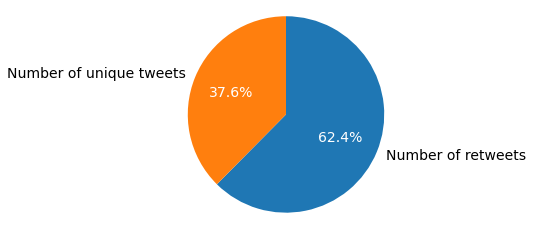

In [6]:
# Data to plot
labels = ['Number of retweets', 'Number of unique tweets']
sizes = [1179, 710]

# Plot
fig, ax = plt.subplots()
patches, texts, autotexts  = ax.pie(sizes, labels = labels, autopct='%1.1f%%',startangle=90, counterclock=False)
[autotext.set_color('white') for autotext in autotexts]
[autotext.set_fontsize(14) for autotext in autotexts]
[text.set_fontsize(14) for text in texts]
plt.axis('equal')
plt.show()

In [78]:
pre_places_count

Rotterdam         6
Doetinchem        3
Sittard-Geleen    2
Dalfsen           2
Soest             1
                 ..
Elburg            1
Oost Gelre        1
Zoetermeer        1
Gulpen-Wittem     1
Eindhoven         1
Name: pre_place, Length: 26, dtype: int64

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


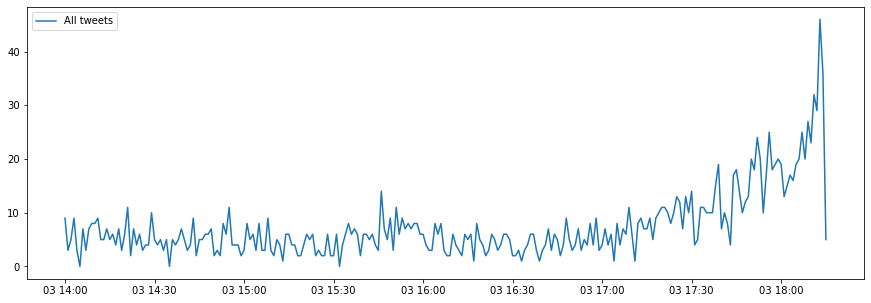

In [79]:
# Resample the dataset to a 15 minute window
data_agg_15_min = data.resample('1Min', on='created_at').sum()
data_agg_15_min.reset_index(inplace=True)

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot()

ax.plot(data_agg_15_min["created_at"], data_agg_15_min["count"], label="All tweets")
[text.set_fontsize(4) for text in texts]
#date_form = DateFormatter("%H:%S")
#ax.xaxis.set_major_formatter(date_form)
plt.legend()
plt.savefig('Rotterdam-tweets-over-time-1815-new.eps', format='eps')
plt.show()

# Add text of websites to the preprocessed text

In [13]:
# Clean the text of the tweet
def clean_text(tweet, hashtag_text='keep', representation = 'string'):
    
    # Parameters
    # hashtag_text, default = 'keep'
        # 'keep' - keeps the hashtag text and only removes the '#' in the text
        # 'lose' - both removes the hashtag text and the '#' in the text
    # representation, default = 'string'
        # 'list' - returns a list of words
        # 'string' - returns a sentence in string format
    
    # Make the tweet lowercase
    tweet = tweet.lower()
    
    # Remove words with less than two characters
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    
    # Remove URLs
    tweet = remove_url(tweet)
    
    # Remove punctuations unless they are part of a digit (such as "5.000")
    tweet = re.sub(r'(?:(?<!\d)[.,;:??]|[.,;:??](?!\d))', '', tweet)
    
    if hashtag_text == 'keep':
        tweet = tweet.replace("#", "")
        tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)", "", tweet).split())
    else:
        # Remove hashtags and mentions
        tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)", "", tweet).split())
    
    # Remove non-alphanumeric charachters, line breaks and tabs
    tweet = ' '.join(re.sub("([:/\!@#$%^&*()_+{}[\];\"\'|?<>~`\-\n\t?])", "", tweet).split())
    
    # Tokenize the tweet
    tweet = word_tokenize(tweet)
    
    # Remove stopwords
    tweet = [w for w in tweet if not w in stop_words]
    
    if representation == 'list':
        return tweet
    else:
        return listToString(tweet)
    
# Function to convert a list to a string
def listToString(s):  
    
    # initialize an empty string 
    str1 = " " 
    
    # return string   
    return (str1.join(s)) 

def remove_url(tweet_text):
    if has_url_regex(tweet_text): 
        url_regex_list = regex_url_extractor(tweet_text)
        for url in url_regex_list:
            tweet_text = tweet_text.replace(url, "")
    return tweet_text

def has_url_regex(tweet_text):
    return regex_url_extractor(tweet_text)

def regex_url_extractor(tweet_text):
    return re.findall('https?:\/\/(?:[-\w\/.]|(?:%[\da-fA-F]{2}))+', tweet_text)

In [15]:
data['pre_text_no_hashtag_website'] = ""

for i in range(len(data)):
    pre_text = data.loc[i, 'pre_text_no_hashtag']
    urls = data.loc[i, 'pre_urls']

    # Set title to None, otherwise you get an error if you don't have a title
    title = None

    # Add the title of the URL to the text variable (if there is a url in the tweet)
    if(urls != None) & (urls != '[]'):
        
        # Make sure urls is a list
        urls = urls.strip('][').split(', ')
        
        for url in urls:
            
            url = url.replace('"', '')
            url = url.replace("'", "")
            
            try:
                
                reqs = requests.get(url)

                # Get the HTML of the URL
                soup = BeautifulSoup(reqs.text, 'html.parser')

                # Get the title of the web page
                title= soup.find_all('title')

                # Get the title of the web page as a string
                if type(title) == str:
                    title = title.get_text()
                elif (title != None) and (title != []):
                    title = title[0].get_text()

                if ("Pagina niet gevonden" in title) or ("Aanmelden bij Facebook" in title) or ("Not Found" in title) or ("Pagina bestaat niet meer" in title) or ("DPG Media Privacy Gate" in title) or ("404" in title) or ("Voordat je verdergaat naar YouTube" in title) or (title=='[]'):
                    title = None
                else:
                    print(url)
                    print(title)
                    title = clean_text(title, 'lose', 'string')
                    print(title)
                    pre_text = pre_text + " " + str(title)
            except:
                pass;
            
    data['pre_text_no_hashtag_website'][i] = pre_text

<ipython-input-15-1f656ffed472>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pre_text_no_hashtag_website'][i] = pre_text


https://www.dagelijksestandaard.nl/2020/06/demonstratie-groningen-nu-al-compleet-achterlijk-organisatie-zwarte-mensen-moeten-vooraan-zitten-witte-mensen-achteraan/
Demonstratie Groningen nu al compleet achterlijk! Organisatie: ‘Zwarte mensen moeten vooraan zitten, witte mensen achteraan’ – De Dagelijkse Standaard
demonstratie groningen compleet achterlijk organisatie ‘ zwarte mensen moeten vooraan zitten witte mensen achteraan ’ – dagelijkse standaard
https://www.telegraaf.nl/nieuws/693884878/feest-met-100-jongeren-op-strand-amsterdam-politie-grijpt-in?utm_source=twitter&utm_medium=social&utm_campaign=seeding-telegraaf
Feest met 100 jongeren op strand Amsterdam: politie grijpt in | Binnenland | Telegraaf.nl
feest 100 jongeren strand amsterdam politie grijpt binnenland telegraaf
https://www.telegraaf.nl/nieuws/693884878/feest-met-100-jongeren-op-strand-amsterdam-politie-grijpt-in?utm_source=twitter&utm_medium=social&utm_campaign=seeding-telegraaf
Feest met 100 jongeren op strand Amsterd

https://www.parool.nl/ts-bca3aa9f
Halsema erkent: we zaten er finaal naast | Het Parool 
halsema erkent zaten finaal naast parool
https://twitter.com/SarahWaltonNews/status/1267912563418857473
[]
https://twitter.com/ZaireKrieger/status/1268068524188196864
[]
https://bit.ly/2yYAA1g
Duizenden mensen bij demonstratie tegen politiegeweld en racisme op Dam - Amsterdam 01-06-2020
duizenden mensen demonstratie politiegeweld racisme dam amsterdam 2020
https://wisenederland.nl/demonstratie-borssele-2020/
Demonstratie Borssele 2020 - WISE - WISE
demonstratie borssele 2020 wise wise
https://www.parool.nl/ts-befc51c7
Hoe had Halsema de demonstratie veiliger kunnen laten verlopen? | Het Parool 
halsema demonstratie veiliger laten verlopen parool
https://twitter.com/girlinled/status/1267552389369860106?s=21
[]
https://twitter.com/McYeji/status/1267552389369860106
[]
https://www.dagelijksestandaard.nl/2020/06/demonstratie-groningen-nu-al-compleet-achterlijk-organisatie-zwarte-mensen-moeten-vooraan-zi

https://www.dagelijksestandaard.nl/2020/06/demonstratie-groningen-nu-al-compleet-achterlijk-organisatie-zwarte-mensen-moeten-vooraan-zitten-witte-mensen-achteraan/
Demonstratie Groningen nu al compleet achterlijk! Organisatie: ‘Zwarte mensen moeten vooraan zitten, witte mensen achteraan’ – De Dagelijkse Standaard
demonstratie groningen compleet achterlijk organisatie ‘ zwarte mensen moeten vooraan zitten witte mensen achteraan ’ – dagelijkse standaard
https://joop.bnnvara.nl/nieuws/femke-halsema-is-de-nederlandse-hillary-clinton
Kee & Van Jole: 'Femke Halsema is de Nederlandse Hillary Clinton'
kee jole femke halsema nederlandse hillary clinton
https://rtvr.nl/o6IU
Demonstratie tegen racisme definitief bij Erasmusbrug - Rijnmond
demonstratie racisme definitief erasmusbrug rijnmond
https://www.at5.nl/artikelen/202068/halsema-waarschuwt-voor-tweede-golf-amsterdam-is-heel-kwetsbaar
Halsema waarschuwt voor tweede golf: 'Amsterdam is heel kwetsbaar' - AT5
halsema waarschuwt tweede golf amste

https://twitter.com/RTLnieuws/status/1267969530564919296
[]
https://nos.nl/l/2336061

        Premier veroordeelt Dam-demonstratie: 'abnormaal' om geen afstand te houden | NOS
    
premier veroordeelt damdemonstratie abnormaal afstand houden nos
https://twitter.com/YoeriAlbrecht/status/1267941804332244992
[]
https://www.duic.nl/algemeen/black-lives-matter-demonstratie-in-utrecht-op-jaarbeursplein/
Black Lives Matter-demonstratie in Utrecht op Jaarbeursplein
black lives matterdemonstratie utrecht jaarbeursplein
https://www.at5.nl/artikelen/202388/oud-hoofdcommissaris-niet-stilleggen-demo-door-halsema-een-vergissing
Oud-hoofdcommissaris: niet stilleggen demo door Halsema 'een vergissing'  - AT5
oudhoofdcommissaris stilleggen demo halsema vergissing at5
https://www.at5.nl/artikelen/202388/oud-hoofdcommissaris-niet-stilleggen-demo-door-halsema-een-vergissing
Oud-hoofdcommissaris: niet stilleggen demo door Halsema 'een vergissing'  - AT5
oudhoofdcommissaris stilleggen demo halsema vergissin

https://www.nos.nl/l/t/2336061

        Premier veroordeelt Dam-demonstratie: 'abnormaal' om geen afstand te houden | NOS
    
premier veroordeelt damdemonstratie abnormaal afstand houden nos
https://twitter.com/NOS/status/1267734917003333632
[]
https://www.telegraaf.nl/t/897808765/
Ook bij demonstratie Rotterdam coronamaatregelen overtreden | Nieuws | Telegraaf.nl
demonstratie rotterdam coronamaatregelen overtreden nieuws telegraaf
https://www.telegraaf.nl/nieuws/897808765/live-ook-bij-demonstratie-rotterdam-coronamaatregelen-overtreden?utm_source=t.co&utm_medium=referral&utm_campaign=twitter
Ook bij demonstratie Rotterdam coronamaatregelen overtreden | Nieuws | Telegraaf.nl
demonstratie rotterdam coronamaatregelen overtreden nieuws telegraaf
https://nos.nl/l/2336061

        Premier veroordeelt Dam-demonstratie: 'abnormaal' om geen afstand te houden | NOS
    
premier veroordeelt damdemonstratie abnormaal afstand houden nos
https://wp.me/p9l1Pt-f1t
Oproep veilige afstand in acht te n

https://www.telegraaf.nl/nieuws/897808765/live-ook-bij-demonstratie-rotterdam-coronamaatregelen-overtreden?utm_source=t.co&utm_medium=referral&utm_campaign=twitter
Ook bij demonstratie Rotterdam coronamaatregelen overtreden | Nieuws | Telegraaf.nl
demonstratie rotterdam coronamaatregelen overtreden nieuws telegraaf
https://www.rtlnieuws.nl/nieuws/nederland/artikel/5142041/racisme-geweld-rotterdam-demonstratie
Access Denied
access denied
https://www.telegraaf.nl/nieuws/897808765/live-ook-bij-demonstratie-rotterdam-coronamaatregelen-overtreden
Ook bij demonstratie Rotterdam coronamaatregelen overtreden | Nieuws | Telegraaf.nl
demonstratie rotterdam coronamaatregelen overtreden nieuws telegraaf
https://nos.nl/l/2336061

        Premier veroordeelt Dam-demonstratie: 'abnormaal' om geen afstand te houden | NOS
    
premier veroordeelt damdemonstratie abnormaal afstand houden nos
https://bit.ly/2XrJnSU
Massale opkomst #BlackLivesMatter-demonstratie Rotterdam
massale opkomst demonstratie rott

https://nos.nl/l/2336061

        Premier veroordeelt Dam-demonstratie: 'abnormaal' om geen afstand te houden | NOS
    
premier veroordeelt damdemonstratie abnormaal afstand houden nos
https://twitter.com/DavinaSteinweg/status/1268208405015146498
[]
https://nos.nl/l/2336061

        Premier veroordeelt Dam-demonstratie: 'abnormaal' om geen afstand te houden | NOS
    
premier veroordeelt damdemonstratie abnormaal afstand houden nos
https://twitter.com/Cambuurfront/status/1268211018716626949
[]
https://nos.nl/l/2336061

        Premier veroordeelt Dam-demonstratie: 'abnormaal' om geen afstand te houden | NOS
    
premier veroordeelt damdemonstratie abnormaal afstand houden nos
https://www.telegraaf.nl/nieuws/897808765/live-ook-bij-demonstratie-rotterdam-coronamaatregelen-overtreden?utm_source=t.co&utm_medium=referral&utm_campaign=twitter
Ook bij demonstratie Rotterdam coronamaatregelen overtreden | Nieuws | Telegraaf.nl
demonstratie rotterdam coronamaatregelen overtreden nieuws telegra

https://www.rtlnieuws.nl/nieuws/nederland/artikel/5142041/racisme-geweld-rotterdam-demonstratie
Access Denied
access denied
https://rtvr.nl/aQlH
Demonstratie Erasmusbrug afgebroken vanwege drukte - Rijnmond
demonstratie erasmusbrug afgebroken vanwege drukte rijnmond
https://www.rtlnieuws.nl/nieuws/nederland/artikel/5142041/racisme-geweld-rotterdam-demonstratie
Access Denied
access denied
https://www.rijnmond.nl/nieuws/196019/Demonstratie-Erasmusbrug-afgebroken-vanwege-drukte
Demonstratie Erasmusbrug afgebroken vanwege drukte - Rijnmond
demonstratie erasmusbrug afgebroken vanwege drukte rijnmond
https://www.rijnmond.nl/nieuws/amp/195977/Demonstratie-tegen-racisme-definitief-bij-Erasmusbrug
Demonstratie tegen racisme definitief bij Erasmusbrug - Rijnmond
demonstratie racisme definitief erasmusbrug rijnmond
https://www.rtlnieuws.nl/nieuws/nederland/artikel/5142041/racisme-geweld-rotterdam-demonstratie
Access Denied
access denied
https://www.rtlnieuws.nl/nieuws/nederland/artikel/5142041/ra

# Predict on complete dataset

In [19]:
vc_text_no_hashtag = pickle.load(open('vectorizer_text_no_hashtag.pickle', 'rb'))
data.reset_index(inplace=True, drop=True)
X_test_text_no_hashtag = data.loc[:, 'pre_text_no_hashtag_website']
X_test_text_no_hashtag_df = pd.DataFrame(vc_text_no_hashtag.transform(X_test_text_no_hashtag.values.astype('U')).todense(), columns=vc_text_no_hashtag.get_feature_names())
X_test_text_no_hashtag_df.reset_index(inplace=True, drop=True)

model = pickle.load(open('support-vector-machines-1.sav', 'rb'))
y_pred = model.predict(X_test_text_no_hashtag_df)

In [20]:
check = pd.DataFrame({"text":X_test_text_no_hashtag, "pred": y_pred})

In [ ]:
# Look at individual tweets
data.loc[1642,][['created_at', 'status_id']]

In [52]:
len(check[check["pred"]==1])

10

In [53]:
check[check["pred"]==1]

,text,pred
390,hulpverlening duizenden mensen demonstratie po...,1
450,gezegd demonstratie belangrijk handhaven burge...,1
1291,live duizenden betogers via demonstratie rotte...,1
1350,live duizenden betogers erasmusbrug via demons...,1
1443,live duizenden betogers via demonstratie rotte...,1
1541,hulpverlening duizenden mensen demonstratie po...,1
1562,politie waarschuwt demonstranten dam via demon...,1
1601,waarom burgemeester vergunning corona voorgoed...,1
1642,politie waarschuwt demonstranten dam via demon...,1
1647,politie waarschuwt demonstranten dam via demon...,1
